In [2]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))
main_dir = os.path.abspath('..')
os.chdir(main_dir)
sys.path.append(main_dir)

import numpy as np
import sympy as sp
import re, copy
from sklearn.model_selection import train_test_split
from PhysicsRegression import PhyReg

### Step1: Load lunar tide data

The observed lunar tide signal data (Er) contains of billions of datapoints, we use 80% of them for OracleNN training and allow at most 20000 datapoints to infer formulas through PhyReg.

In [3]:
num_xy = 10000

x_to_fit = []
y_to_fit = []

data = np.load("./data/physics_data/To_QH_Data_0.npy")
E_a, E_r, LLT, L_Shell, MLT = data

assert not np.any(np.isnan(E_a))
assert not np.any(np.isnan(E_r))
assert not np.any(np.isnan(LLT))
assert not np.any(np.isnan(L_Shell))
assert not np.any(np.isnan(MLT))

LLT = LLT / 24 * 10
MLT = MLT / 24 * 10

#E_r / L_Shell, MLT, LLT
x_to_fit.append(np.array([
    L_Shell, MLT, LLT
]).copy().T)
y_to_fit.append(E_r.copy().reshape((-1, 1)))

for i in range(len(x_to_fit)):
    x_train, x_test, y_train, y_test = train_test_split(x_to_fit[i], y_to_fit[i], test_size=0.2, random_state=2024)
    x_to_fit[i] = x_train[:num_xy]
    y_to_fit[i] = y_train[:num_xy]

np.random.seed(2024)

### Step2: Inference with PhyReg

In [4]:
np.random.seed(2024)

phyreg = PhyReg(
    path = "./model.pt",
    max_len=20000,
)

phyreg.fit(
    x_to_fit, y_to_fit, 
    use_Divide=True, 
    use_MCTS=False, 
    use_GP=False, 
    use_pysr_init=True, 
    use_const_optimization=False,
    verbose=False,
    oracle_name="physical5",
    oracle_file="./physical/data/oracle_model_case5/",
    oracle_bs=512, oracle_lr=0.005, oracle_epoch=100,
    use_seperate_type=["id"],
    variable_scale=[-3, 10],
    save_oracle_model=True
)

In [5]:
np.random.seed(2024)

best_gens = phyreg.constant_optimization(phyreg.best_gens, x_to_fit, y_to_fit)
phyreg.express_skeleton(best_gens, use_sp=True)
phyreg.express_best_gens(best_gens, use_sp=True)

idx          : 0
expr skeleton: C_0*(C_1 - C_2*cos(C_3*x_2))*(C_4*cos(C_5*x_1) - C_6)/((C_7 - C_8*cos(C_9*x_1 - C_10))*(C_11*x_0**2 - C_12*x_0 + C_13))
constants    : -0.973 1.534 0.018 0.844 3.114 1.245 3.404 0.005 0.0 3.098 10.772 178.673 111.458 139.139

idx : 0
expr: -0.973176522399925*(1.53410323125474 - 0.0175223212029913*cos(0.8438530266858629*x_2))*(3.11391876553989*cos(1.2449556566011122*x_1) - 3.40366008360158)/((0.0047631484737234 - 0.000227982500542901*cos(3.0979855618917296*x_1 - 10.772148586643738))*(178.672822071876*x_0**2 - 111.457713795054*x_0 + 139.138747408153))
mse : 0.24301382500948715



### Step3: plot the predicted formula

Since the formula contains of 3 variables, we plot 3 heatmaps on different dimensions to visualize.

We first compute the averate heatmap of billions datapoints, including both observed data and predicted data, before we plot the heatmap.

In [6]:
import matplotlib.pyplot as plt
from numpy import sin, cos

Er_pred = -3361.96979708501*(4.69508588290558*cos(1.2245041948637305*MLT) - 4.76106584752594)*(1.44210575590488*cos(1.92869427250588*LLT) - 56.5587717274766)/((-18.9407244915929*cos(1.0335027857758747*MLT - 8.972576449562819) - 116.536793403173)*(1263.72287941255*L_Shell**2 - 885.356514754769*L_Shell + 1067.1616336831))

gridsize = 36
xbins = np.linspace(1.1, 6.2, gridsize + 1)
ybins = np.linspace(0, 10, gridsize + 1)
zbins = np.linspace(0, 10, gridsize + 1)

heatmap, _ = np.histogramdd(np.array([L_Shell, MLT, LLT]).T, bins=[xbins, ybins, zbins], weights=E_r)
counts, _  = np.histogramdd(np.array([L_Shell, MLT, LLT]).T, bins=[xbins, ybins, zbins])
counts[counts <= 0.8] = 1
average_heatmap_er = np.divide(heatmap, counts)
average_heatmap_er[np.abs(average_heatmap_er) < 1e-10] = np.nan

heatmap_our, _ = np.histogramdd(np.array([L_Shell, MLT, LLT]).T, bins=[xbins, ybins, zbins], weights=Er_pred)
counts_our, _  = np.histogramdd(np.array([L_Shell, MLT, LLT]).T, bins=[xbins, ybins, zbins])
counts_our[counts_our <= 0.8] = 1
average_heatmap_our_er = np.divide(heatmap_our, counts_our)
average_heatmap_our_er[np.abs(average_heatmap_our_er) < 1e-10] = np.nan

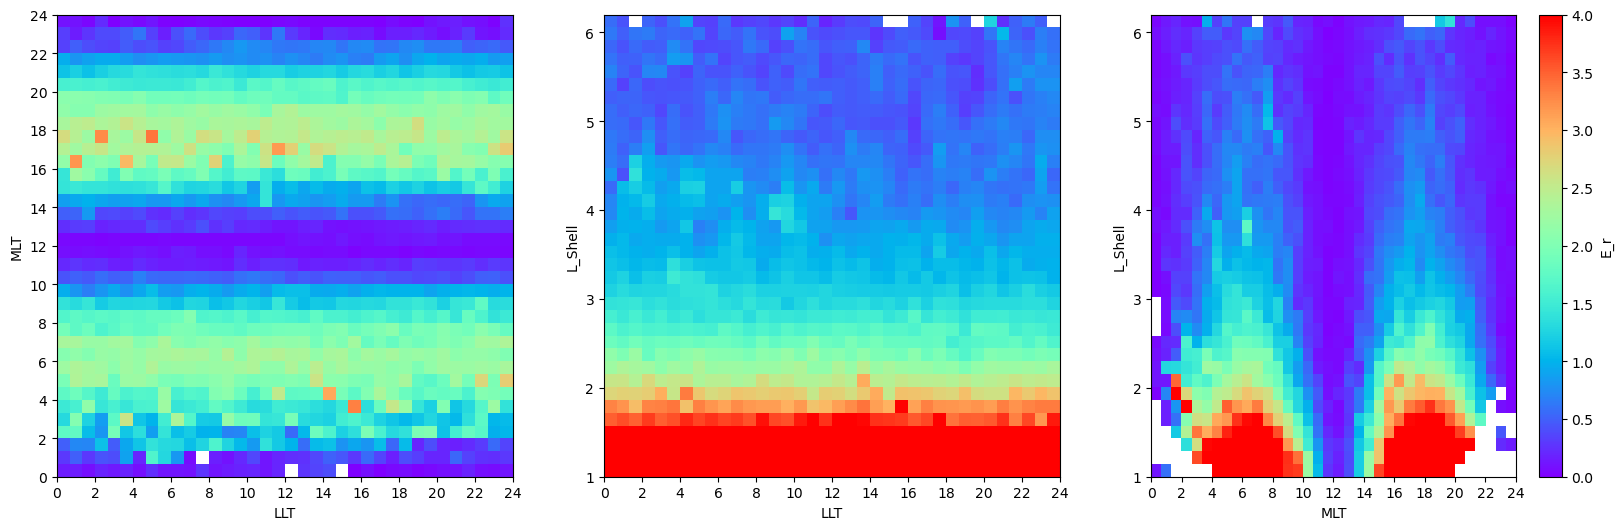

In [7]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.imshow(average_heatmap_er[8,:,:], origin='lower', vmin=0, vmax=4, cmap='rainbow', aspect='auto')
plt.xlabel('LLT')
plt.ylabel('MLT')
plt.xticks(np.linspace(0, average_heatmap_er.shape[0], 13)-0.5, np.arange(0, 26, 2))
plt.yticks(np.linspace(0, average_heatmap_er.shape[0], 13)-0.5, np.arange(0, 26, 2))

plt.subplot(1,3,2)
plt.imshow(average_heatmap_er[:,8,:], origin='lower', vmin=0, vmax=4, cmap='rainbow', aspect='auto')
plt.xlabel('LLT')
plt.ylabel('L_Shell')
plt.xticks(np.linspace(0, average_heatmap_er.shape[0], 13)-0.5, np.arange(0, 26, 2))
plt.yticks((np.arange(1, 7)-1) / (6.3 - 1.1) * average_heatmap_er.shape[0] - 0.5, np.arange(1, 7))

plt.subplot(1,3,3)
plt.imshow(average_heatmap_er[:,:,8], origin='lower', vmin=0, vmax=4, cmap='rainbow', aspect='auto')
plt.colorbar(label='E_r')
plt.xlabel('MLT')
plt.ylabel('L_Shell')
plt.xticks(np.linspace(0, average_heatmap_er.shape[0], 13)-0.5, np.arange(0, 26, 2))
plt.yticks((np.arange(1, 7)-1) / (6.3 - 1.1) * average_heatmap_er.shape[0] - 0.5, np.arange(1, 7))

plt.show()

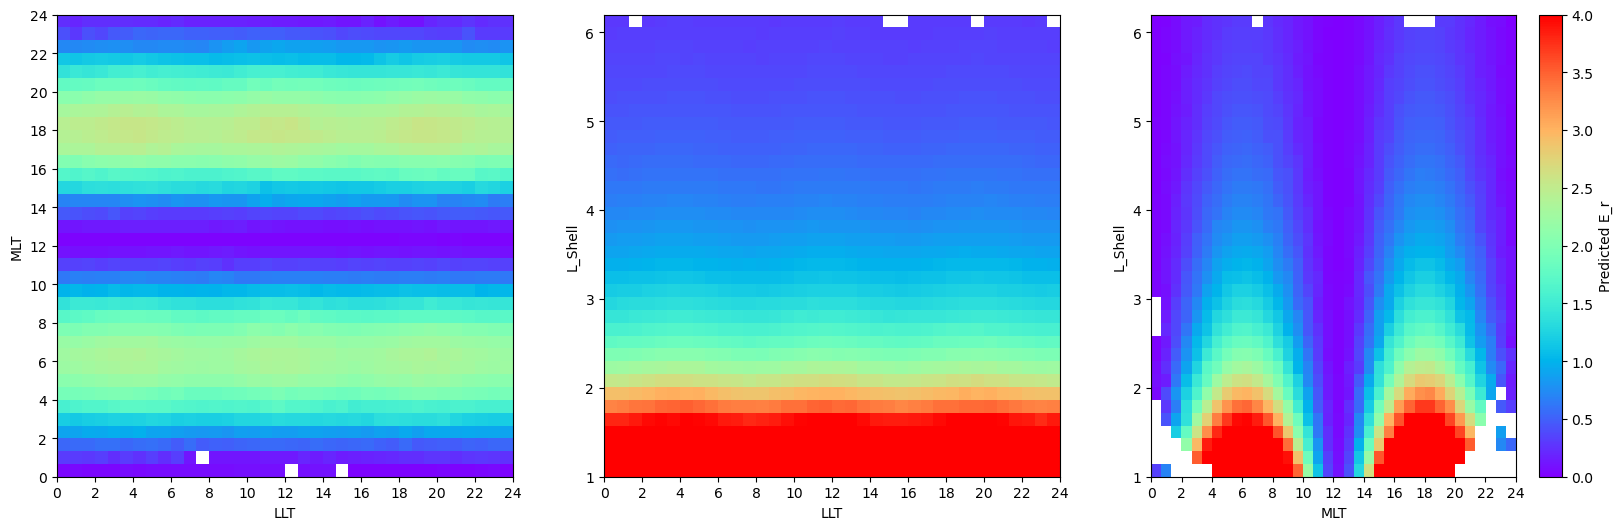

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.imshow(average_heatmap_our_er[8,:,:], origin='lower', vmin=0, vmax=4, cmap='rainbow', aspect='auto')
plt.xlabel('LLT')
plt.ylabel('MLT')
plt.xticks(np.linspace(0, average_heatmap_our_er.shape[0], 13)-0.5, np.arange(0, 26, 2))
plt.yticks(np.linspace(0, average_heatmap_our_er.shape[0], 13)-0.5, np.arange(0, 26, 2))

plt.subplot(1,3,2)
plt.imshow(average_heatmap_our_er[:,8,:], origin='lower', vmin=0, vmax=4, cmap='rainbow', aspect='auto')
plt.xlabel('LLT')
plt.ylabel('L_Shell')
plt.xticks(np.linspace(0, average_heatmap_our_er.shape[0], 13)-0.5, np.arange(0, 26, 2))
plt.yticks((np.arange(1, 7)-1) / (6.3 - 1.1) * average_heatmap_our_er.shape[0] - 0.5, np.arange(1, 7))

plt.subplot(1,3,3)
plt.imshow(average_heatmap_our_er[:,:,8], origin='lower', vmin=0, vmax=4, cmap='rainbow', aspect='auto')
plt.colorbar(label='Predicted E_r')
plt.xlabel('MLT')
plt.ylabel('L_Shell')
plt.xticks(np.linspace(0, average_heatmap_our_er.shape[0], 13)-0.5, np.arange(0, 26, 2))
plt.yticks((np.arange(1, 7)-1) / (6.3 - 1.1) * average_heatmap_our_er.shape[0] - 0.5, np.arange(1, 7))

plt.show()